<a href="https://colab.research.google.com/github/RFesser/hello-world/blob/master/Curvatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
# install GraphRicciCurvature package

!pip install GraphRicciCurvature

# import packages

import networkx as nx
import matplotlib.pyplot as plt
from time import perf_counter
import numpy as np

from GraphRicciCurvature.FormanRicci import FormanRicci
from GraphRicciCurvature.OllivierRicci import OllivierRicci


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [124]:
def plot_my_graph(G, pos, ax = None, node_col = "white", 
                  edge_lst = [], edge_col = "lightgrey", edge_lab = {},
                  bbox = None, color_map = "Set3", alpha = 1.0):
    node_options = {
        "font_size": 12, 
        "font_color": "black",
        "node_size": 300, 
        "cmap": plt.get_cmap(color_map),
        "alpha": alpha,
        "edgecolors": "black",
        "linewidths": 0.5,   
        "with_labels": True,
        "edgelist": None
        }
    edge_options = {
        "width": 0.5
        }
    fig = plt.figure(figsize=(15,15))
    nx.draw_networkx (G, pos, node_color = node_col, edge_color = edge_col, **node_options)
    nx.draw_networkx_edges (G, pos, edge_lst, edge_color = edge_col, **edge_options)
    nx.draw_networkx_edge_labels(G, pos, label_pos = 0.5, edge_labels = edge_lab, rotate=False, bbox = bbox)
    plt.gca().margins(0.20)
    plt.show()

In [125]:
def remove_permutations(ll):
    i = 0
    z = len(ll)
    while i < z:
        j = i + 1
        a = sorted(ll[i])
        while j < z:
            # falls Permutation, dann entfernen.  Liste wird dadurch kürzer, daher jedesmal len(ll) überprüfen 
            b = sorted(ll[j])
            if a == b:
                ll.pop(j)
                z = len(ll)
                break
            else:
                j += 1
        i += 1
    return ll

In [126]:
def simple_cycles(G, limit):
    subG = type(G)(G.edges())
    sccs = list(nx.strongly_connected_components(subG))
    while sccs:
        scc = sccs.pop()
        startnode = scc.pop()
        path = [startnode]
        blocked = set()
        blocked.add(startnode)
        stack = [(startnode, list(subG[startnode]))]

        while stack:
            thisnode, nbrs = stack[-1]

            if nbrs and len(path) < limit:
                nextnode = nbrs.pop()
                if nextnode == startnode:
                    yield path[:]
                elif nextnode not in blocked:
                    path.append(nextnode)
                    stack.append((nextnode, list(subG[nextnode])))
                    blocked.add(nextnode)
                    continue
            if not nbrs or len(path) >= limit:
                blocked.remove(thisnode)
                stack.pop()
                path.pop()
        subG.remove_node(startnode)
        H = subG.subgraph(scc)
        sccs.extend(list(nx.strongly_connected_components(H)))

In [127]:
def fr_curvature (G, ni, nj):
    '''
    computes the Forman-Ricci curvature of a given edge 
    
    Parameters
    ----------
    G : Graph
    ni : node i
    nj : node j

    Returns
    -------
    frc : int
        Forman Ricci curvature of the edge connecting nodes i and j

    '''
    frc = 4 - G.degree(ni) - G.degree(nj)
    return frc 

In [128]:
def afr_curvature (G, ni, nj, m):
    '''
    computes the Augmented Forman-Ricci curvature of a given edge 
    includes 3-cycles in calculation 
    
    Parameters
    ----------
    G : Graph
    ni : node i
    nj : node j
    m : number of triangles containing the edge between node i and j

    Returns
    -------
    afrc : int
        Forman Ricci curvature of the edge connecting nodes i and j   
    '''
    afrc = 4 - G.degree(ni) - G.degree(nj) + 3*m
    return afrc

In [129]:
def afr4_curvature (G, ni, nj, t, q):
    '''
    computes the Augmented Forman-Ricci curvature of a given edge, 
    includes 3- and 4-cycles in calculation 
    
    Parameters
    ----------
    G : Graph
    ni : node i
    nj : node j
    t : number of triangles containing the edge between node i and j
    q : number of quadrangles containing the edge between node i and j

    Returns
    -------
    afrc4 : int
        enhanced Forman Ricci curvature of the edge connecting nodes i and j   
    '''
    afrc4 = 4 - G.degree(ni) - G.degree(nj) + 3*t + 2*q
    return afrc4

In [130]:
def afr5_curvature (G, ni, nj, t, q, p):
    '''
    computes the Augmented Forman-Ricci curvature of a given edge 
    includes 3-, 4- and 5-cycles in calculation 
    
    Parameters
    ----------
    G : Graph
    ni : node i
    nj : node j
    t : number of triangles containing the edge between node i and j
    q : number of quadrangles containing the edge between node i and j
    p : number of pentagons containing the edge between node i and j

    Returns
    -------
    afrc5 : int
        enhanced Forman Ricci curvature of the edge connecting nodes i and j   
    '''
    afrc5 = 4 - G.degree(ni) - G.degree(nj) + 3*t + 2*q + 1*p
    return afrc5

In [131]:
def init_edge_attributes(G):
    curv_names = ["frc", "afrc", "afrc4", "afrc5"] 
    for (u,v) in list(G.edges()):
        for i in range(3,6):
            G.edges[u,v][cyc_names[i]] = []
        for cn in curv_names:
            G.edges[u,v][cn] = 0

In [132]:
def set_edge_attributes_2 (G, ll, i):
    for l in ll:     # für jeden Zyklus in der Liste der Zyklen
        for e1 in range(0, i): 
            if e1 == i-1:
                e2 = 0
            else:
                e2 = e1 + 1
            u = l[e1]
            v = l[e2]
            G.edges[u,v][cyc_names[i]].append(l)

In [133]:
def get_orc_edge_curvatures (G):          
    # compute the Ollivier-Ricci curvature of the given graph G
    orc = OllivierRicci(G, alpha=0.5, verbose="ERROR")
    orc.compute_ricci_curvature()
    # transfer curvatire values from orc.G to G 
    for (u,v) in list(orc.G.edges()):               # für jede Kante
        G.edges[u,v]["orc"] = orc.G.edges[u,v]["ricciCurvature"]
        # print("ORC: ", orc.G.edges[u,v]["ricciCurvature"], ("  -  G: ",G.edges[u,v]["orc"])

In [134]:
def get_edge_curvatures (G):            
    for (u,v) in list(G.edges()):               # für jede Kante
        tr = len(G.edges[u,v][cyc_names[3]])
        qu = len(G.edges[u,v][cyc_names[4]])
        pe = len(G.edges[u,v][cyc_names[5]])
        G.edges[u,v]["frc"] = fr_curvature(G, u, v)        
        G.edges[u,v]["afrc"] = afr_curvature(G, u, v, tr)
        G.edges[u,v]["afrc4"] = afr4_curvature(G, u, v, tr, qu)
        G.edges[u,v]["afrc5"] = afr5_curvature(G, u, v, tr, qu, pe)    

In [135]:
def show_curv_min_max_values (h_data):
    print("\nMin/Max Curvature values:")
    for k in h_data.keys():
        print(str(k).ljust(8), 
              "{0:<5s} {1:8.4f}".format("Min:", h_data[k]["bin_min"]), "  ",
              "{0:<5s} {1:8.4f}".format("Max:", h_data[k]["bin_max"])
              )
    print()

In [136]:
def get_bin_width (b_min, b_max, num_bin_lim):
    scaling = 1
    multiplier = 10
    # print("b_min:", b_min, "b_max:", b_max, "num_bin_lim:", num_bin_lim, "scaling:", scaling, "multiplier:", multiplier)
    b_width = (b_max - b_min) // 40 + 1
    if abs(b_max) < 1 and abs(b_min) < 1:
        while (b_max - b_min)/scaling < num_bin_lim / 10:
            scaling /= multiplier    
        b_width = scaling
    return b_width

In [137]:
def show_histos (h_data, title_str, my_nrows = 2, my_ncols = 3, my_bin_num = 40):
    fig, axes = plt.subplots(nrows=my_nrows, ncols=my_ncols, sharey = True, figsize=(16,10))
    for i,k in enumerate(h_data.keys()):
        r = i // my_ncols
        c = i % my_ncols
        bin_width = get_bin_width(h_data[k]["bin_min"], h_data[k]["bin_max"], my_bin_num)
        axes[r,c].hist(h_data[k]["curv"], bins = np.arange(h_data[k]["bin_min"], h_data[k]["bin_max"] + bin_width, bin_width), edgecolor = "white")
        axes[r,c].set_title(h_data[k]["title"])
        axes[r,c].title.set_size(16)
        axes[r,c].tick_params(axis='both', labelsize=16)
        axes[r,c].grid(visible=True, axis="both")
    fig.suptitle(title_str, size=16)
    plt.show()   

In [138]:
def show_correlation_coeffs (h_data):
    print("\nCorrelation coefficients:")
    ks = list(h_data.keys())
    for i in range(len(ks)):
        for j in range(i+1, len(ks)):
            s = h_data[ks[i]]["title"] + " / " + h_data[ks[j]]["title"]
            c = np.corrcoef(h_data[ks[i]]["curv"], h_data[ks[j]]["curv"])[1][0]
            print(s.ljust(55,"."), f"{c:8.5f}")
        print()

In [139]:
def show_curv_data (G, title_str):
    h_data = {"orc":  {"curv": [d["orc"]   for u,v,d in G.edges.data()], "bin_min":0, "bin_max":0, "title":"Ollivier Ricci (OR)"},
              "frc":  {"curv": [d["frc"]   for u,v,d in G.edges.data()], "bin_min":0, "bin_max":0, "title":"Forman Ricci (FR)"},
              "afrc": {"curv": [d["afrc"]  for u,v,d in G.edges.data()], "bin_min":0, "bin_max":0, "title":"Augm. FR curv. (triangles)"},
              "afrc4":{"curv": [d["afrc4"] for u,v,d in G.edges.data()], "bin_min":0, "bin_max":0, "title":"AFR curv. (tri/quad)"},
              "afrc5":{"curv": [d["afrc5"] for u,v,d in G.edges.data()], "bin_min":0, "bin_max":0, "title":"AFR curv. (tri/quad/pent)"}
              }
    
    for k in h_data.keys():
        # print("h_data.keys: ", k)
        # h_data[k]["bin_min"] = int(min(h_data[k]["curv"]))
        # h_data[k]["bin_max"] = int(max(h_data[k]["curv"]))
        h_data[k]["bin_min"] = min(h_data[k]["curv"])
        h_data[k]["bin_max"] = max(h_data[k]["curv"])
        
    show_curv_min_max_values (h_data)
    show_histos (h_data, title_str, my_nrows = 2, my_ncols = 3, my_bin_num = 40)
    show_correlation_coeffs(h_data)

In [140]:
cyc_names = {3:"triangles", 4:"quadrangles", 5:"pentagons"}        


In [141]:
def build_size_list (k, l):
    ll = [k  for i in range(l)]
    return ll

In [142]:
def build_prob_list (n, p_in, p_out):
    ll = []
    for i in range(n):    
        temp_l = [p_out  for j in range(0,i)] + [p_in] + [p_out  for j in range(i+2,n+1)]
        ll.append(temp_l)
    return ll

In [143]:
def calculate_SBM(k, l, p_in, p_out, title_str):
    print("k:",k," l:",l," p_in:",p_in," p_out:",p_out)
    sizes = build_size_list(k, l)
    probs = build_prob_list(l, p_in, p_out)
    
    G = nx.stochastic_block_model(sizes, probs, seed = 0)
    init_edge_attributes(G)
      
    H = G.to_directed()
    
    pos1 = nx.kamada_kawai_layout(H)
    blocks = [v["block"]  for u,v in H.nodes.data()]
    # plot_my_graph(H, pos1, node_col = blocks)
    
    cycles = []
    for c in simple_cycles(H, 6):
        cycles.append(c) 
    
    d = dict()
    for i in range(3,6):
        d[i] = [c  for c in cycles  if len(c) == i]
        d[i] = remove_permutations(d[i])
        set_edge_attributes_2(G, d[i], i)
        
    get_orc_edge_curvatures (G)
    get_edge_curvatures (G)
    show_curv_data (G, title_str)
        
    return d

In [144]:
def calculate_SBMs():
    ll_k = [5,10,15,20]
    k_def = 15
    ll_l = [2,3,4,5]
    l_def = 5
    ll_p_in = [0.6, 0.7, 0.8, 0.9]
    p_in_def = 0.7
    ll_p_out = [0.05, 0.03, 0.02, 0.01]
    p_out_def = 0.05
    for k in ll_k:
        s = "Variation of community size / k = " + str(k) + "\n" + \
            "k=" + str(k) + "  l=" + str(l_def) + "  p_in=" + str(p_in_def) + "  p_out=" + str(p_out_def)
        calculate_SBM(k, l_def, p_in_def, p_out_def, s)
    for l in ll_l:
        s = "Variation of number of communities / l = " + str(l) + "\n" + \
            "k=" + str(k_def) + "  l=" + str(l) +  "  p_in=" + str(p_in_def) + "  p_out=" + str(p_out_def)
        d = calculate_SBM(k_def, l, p_in_def, p_out_def, s)
    for p_in in ll_p_in:
        s = "Variation of p_in / p_in = " + str(p_in) + "\n" + \
            "k=" + str(k_def) + "  l=" + str(l_def) +  "  p_in=" + str(p_in) + "  p_out=" + str(p_out_def)
        calculate_SBM(k_def, l_def, p_in, p_out_def, s)
    for p_out in ll_p_out:
        s = "Variation of p_out / p_out = " + str(p_out) + "\n" + \
            "k=" + str(k_def) + "  l=" + str(l_def) +  "  p_in=" + str(p_in_def) + "  p_out=" + str(p_out)
        calculate_SBM(k_def, l_def, p_in_def, p_out, s)
    
    return d

k: 5  l: 5  p_in: 0.7  p_out: 0.05

Min/Max Curvature values:
orc      Min:   -0.3929    Max:    0.4583
frc      Min:   -9.0000    Max:   -2.0000
afrc     Min:   -9.0000    Max:    3.0000
afrc4    Min:   -7.0000    Max:   11.0000
afrc5    Min:   -3.0000    Max:   16.0000



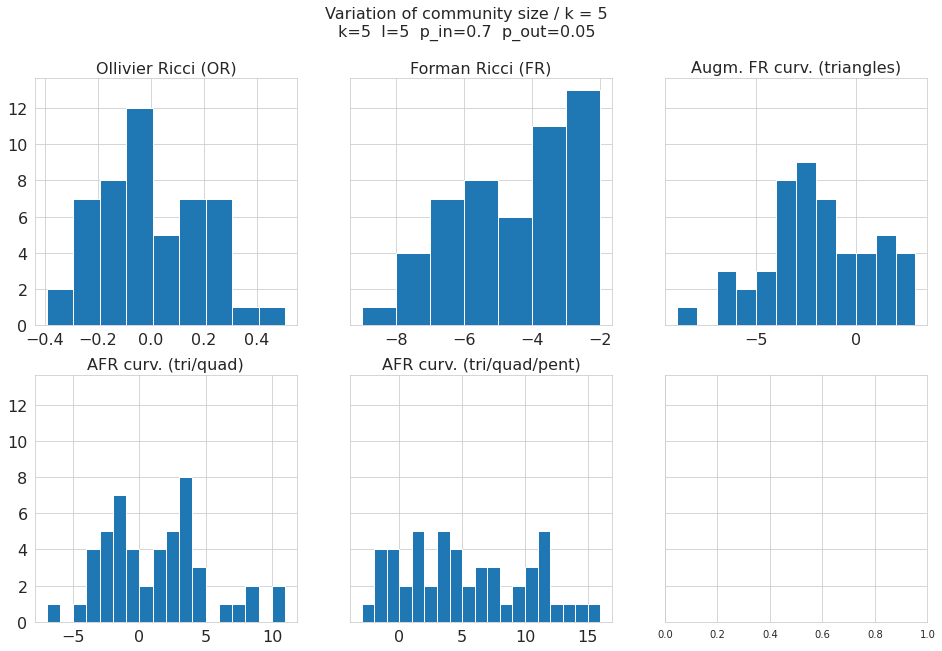


Correlation coefficients:
Ollivier Ricci (OR) / Forman Ricci (FR)................  0.13778
Ollivier Ricci (OR) / Augm. FR curv. (triangles).......  0.82233
Ollivier Ricci (OR) / AFR curv. (tri/quad).............  0.87949
Ollivier Ricci (OR) / AFR curv. (tri/quad/pent)........  0.64490

Forman Ricci (FR) / Augm. FR curv. (triangles).........  0.39939
Forman Ricci (FR) / AFR curv. (tri/quad)............... -0.05720
Forman Ricci (FR) / AFR curv. (tri/quad/pent).......... -0.44256

Augm. FR curv. (triangles) / AFR curv. (tri/quad)......  0.78305
Augm. FR curv. (triangles) / AFR curv. (tri/quad/pent).  0.35749

AFR curv. (tri/quad) / AFR curv. (tri/quad/pent).......  0.80829


k: 10  l: 5  p_in: 0.7  p_out: 0.05

Min/Max Curvature values:
orc      Min:   -0.5625    Max:    0.4000
frc      Min:  -21.0000    Max:   -5.0000
afrc     Min:  -18.0000    Max:    6.0000
afrc4    Min:  -15.0000    Max:  102.0000
afrc5    Min:   -2.0000    Max:  311.0000



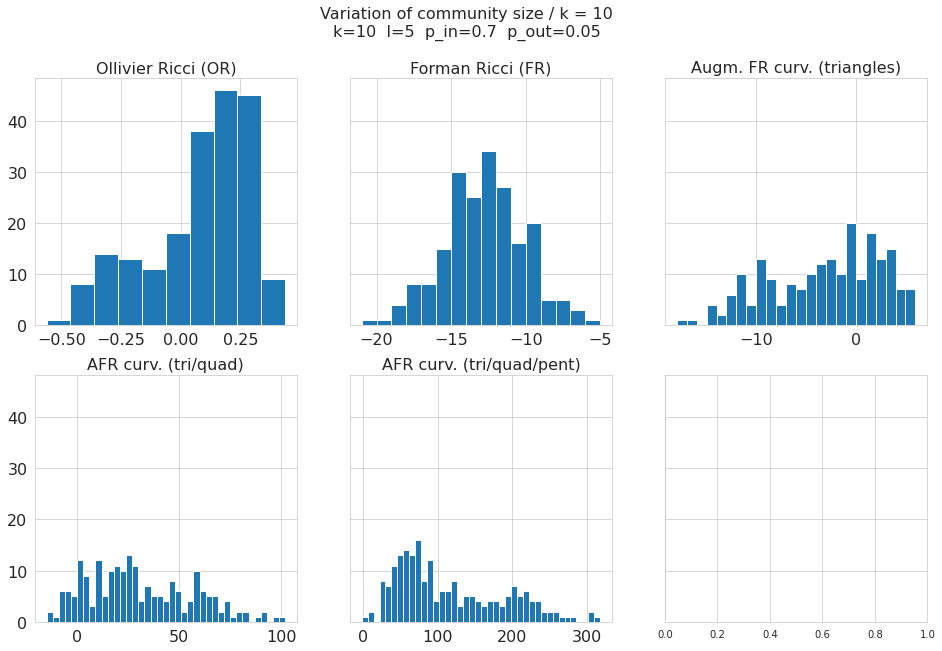


Correlation coefficients:
Ollivier Ricci (OR) / Forman Ricci (FR)................  0.16022
Ollivier Ricci (OR) / Augm. FR curv. (triangles).......  0.91620
Ollivier Ricci (OR) / AFR curv. (tri/quad).............  0.75417
Ollivier Ricci (OR) / AFR curv. (tri/quad/pent)........  0.63605

Forman Ricci (FR) / Augm. FR curv. (triangles).........  0.05303
Forman Ricci (FR) / AFR curv. (tri/quad)............... -0.33982
Forman Ricci (FR) / AFR curv. (tri/quad/pent).......... -0.46545

Augm. FR curv. (triangles) / AFR curv. (tri/quad)......  0.83322
Augm. FR curv. (triangles) / AFR curv. (tri/quad/pent).  0.71629

AFR curv. (tri/quad) / AFR curv. (tri/quad/pent).......  0.96925


k: 15  l: 5  p_in: 0.7  p_out: 0.05

Min/Max Curvature values:
orc      Min:   -0.4391    Max:    0.4167
frc      Min:  -29.0000    Max:  -12.0000
afrc     Min:  -26.0000    Max:    8.0000
afrc4    Min:  -20.0000    Max:  204.0000
afrc5    Min:   43.0000    Max:  1017.0000



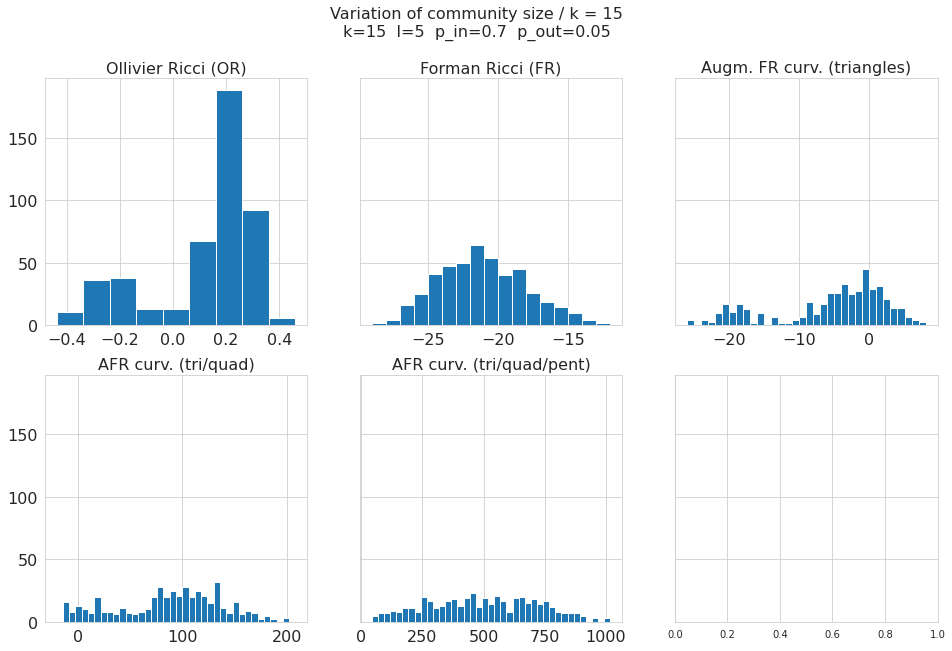


Correlation coefficients:
Ollivier Ricci (OR) / Forman Ricci (FR)................  0.11191
Ollivier Ricci (OR) / Augm. FR curv. (triangles).......  0.94509
Ollivier Ricci (OR) / AFR curv. (tri/quad).............  0.84907
Ollivier Ricci (OR) / AFR curv. (tri/quad/pent)........  0.74322

Forman Ricci (FR) / Augm. FR curv. (triangles).........  0.15090
Forman Ricci (FR) / AFR curv. (tri/quad)............... -0.25266
Forman Ricci (FR) / AFR curv. (tri/quad/pent).......... -0.39898

Augm. FR curv. (triangles) / AFR curv. (tri/quad)......  0.83609
Augm. FR curv. (triangles) / AFR curv. (tri/quad/pent).  0.71492

AFR curv. (tri/quad) / AFR curv. (tri/quad/pent).......  0.96491


k: 20  l: 5  p_in: 0.7  p_out: 0.05

Min/Max Curvature values:
orc      Min:   -0.2981    Max:    0.4021
frc      Min:  -42.0000    Max:  -19.0000
afrc     Min:  -38.0000    Max:   13.0000
afrc4    Min:  -15.0000    Max:  486.0000
afrc5    Min:  173.0000    Max:  3501.0000



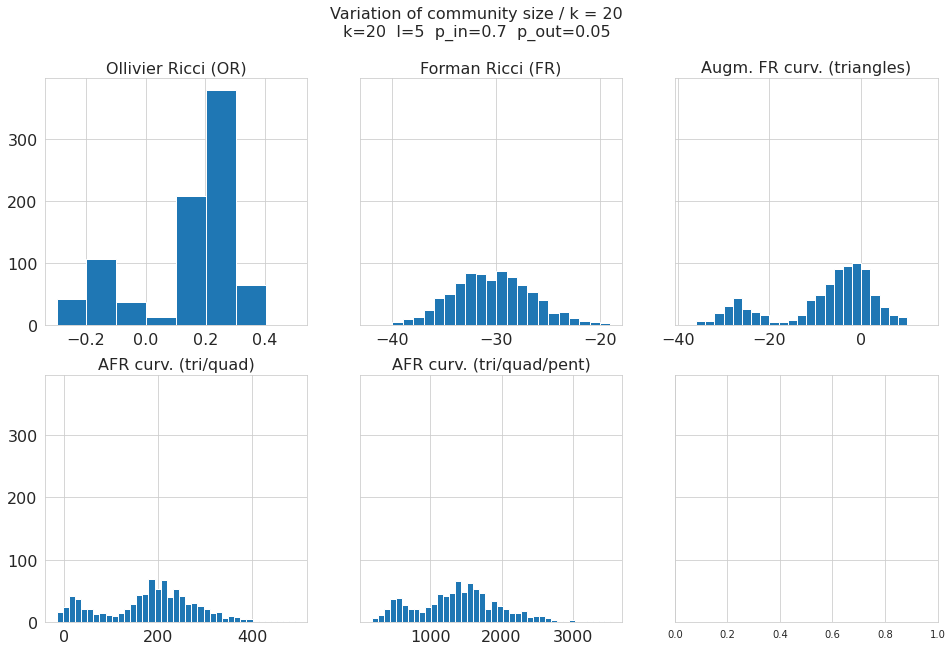


Correlation coefficients:
Ollivier Ricci (OR) / Forman Ricci (FR)................  0.02722
Ollivier Ricci (OR) / Augm. FR curv. (triangles).......  0.95601
Ollivier Ricci (OR) / AFR curv. (tri/quad).............  0.86295
Ollivier Ricci (OR) / AFR curv. (tri/quad/pent)........  0.78507

Forman Ricci (FR) / Augm. FR curv. (triangles).........  0.06008
Forman Ricci (FR) / AFR curv. (tri/quad)............... -0.31489
Forman Ricci (FR) / AFR curv. (tri/quad/pent).......... -0.42844

Augm. FR curv. (triangles) / AFR curv. (tri/quad)......  0.86575
Augm. FR curv. (triangles) / AFR curv. (tri/quad/pent).  0.77949

AFR curv. (tri/quad) / AFR curv. (tri/quad/pent).......  0.97726


k: 15  l: 2  p_in: 0.7  p_out: 0.05

Min/Max Curvature values:
orc      Min:   -0.3810    Max:    0.4670
frc      Min:  -23.0000    Max:  -10.0000
afrc     Min:  -19.0000    Max:   13.0000
afrc4    Min:  -11.0000    Max:  261.0000
afrc5    Min:   46.0000    Max:  1147.0000



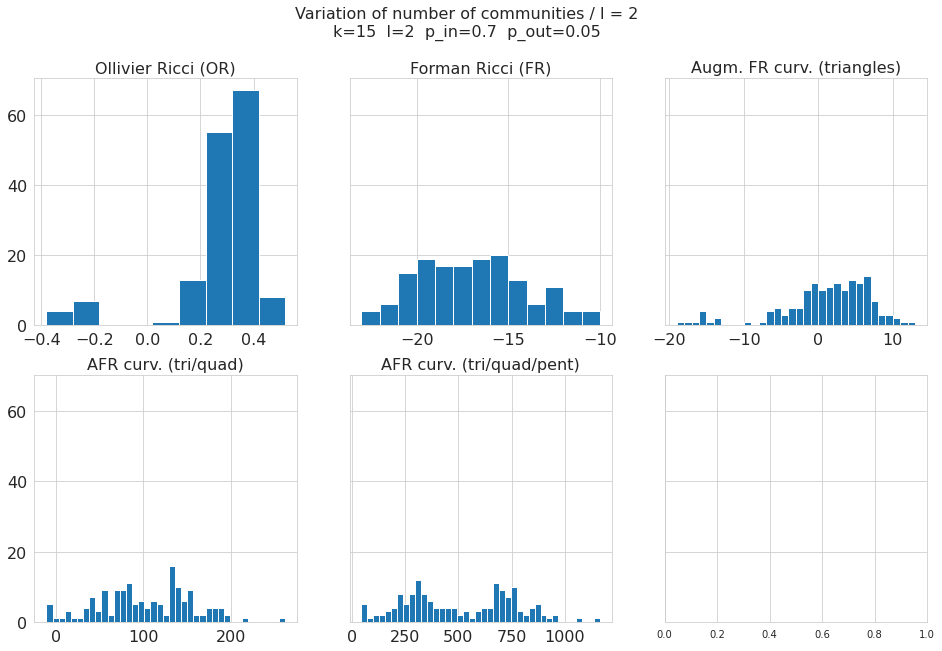


Correlation coefficients:
Ollivier Ricci (OR) / Forman Ricci (FR)................ -0.17731
Ollivier Ricci (OR) / Augm. FR curv. (triangles).......  0.91625
Ollivier Ricci (OR) / AFR curv. (tri/quad).............  0.71219
Ollivier Ricci (OR) / AFR curv. (tri/quad/pent)........  0.61878

Forman Ricci (FR) / Augm. FR curv. (triangles)......... -0.36553
Forman Ricci (FR) / AFR curv. (tri/quad)............... -0.69357
Forman Ricci (FR) / AFR curv. (tri/quad/pent).......... -0.71961

Augm. FR curv. (triangles) / AFR curv. (tri/quad)......  0.78737
Augm. FR curv. (triangles) / AFR curv. (tri/quad/pent).  0.69804

AFR curv. (tri/quad) / AFR curv. (tri/quad/pent).......  0.97545


k: 15  l: 3  p_in: 0.7  p_out: 0.05

Min/Max Curvature values:
orc      Min:   -0.3909    Max:    0.4500
frc      Min:  -28.0000    Max:  -11.0000
afrc     Min:  -24.0000    Max:   11.0000
afrc4    Min:   -9.0000    Max:  252.0000
afrc5    Min:   49.0000    Max:  1182.0000



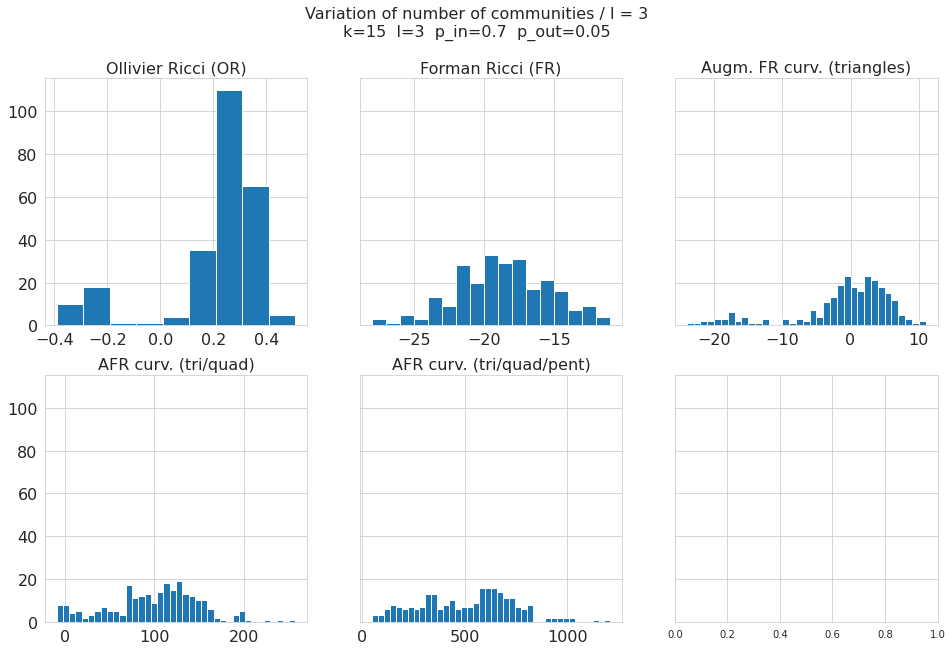


Correlation coefficients:
Ollivier Ricci (OR) / Forman Ricci (FR)................  0.05783
Ollivier Ricci (OR) / Augm. FR curv. (triangles).......  0.94271
Ollivier Ricci (OR) / AFR curv. (tri/quad).............  0.75631
Ollivier Ricci (OR) / AFR curv. (tri/quad/pent)........  0.65460

Forman Ricci (FR) / Augm. FR curv. (triangles)......... -0.02984
Forman Ricci (FR) / AFR curv. (tri/quad)............... -0.46613
Forman Ricci (FR) / AFR curv. (tri/quad/pent).......... -0.54917

Augm. FR curv. (triangles) / AFR curv. (tri/quad)......  0.80483
Augm. FR curv. (triangles) / AFR curv. (tri/quad/pent).  0.69912

AFR curv. (tri/quad) / AFR curv. (tri/quad/pent).......  0.97255


k: 15  l: 4  p_in: 0.7  p_out: 0.05

Min/Max Curvature values:
orc      Min:   -0.5773    Max:    0.4135
frc      Min:  -29.0000    Max:  -12.0000
afrc     Min:  -26.0000    Max:   11.0000
afrc4    Min:  -18.0000    Max:  219.0000
afrc5    Min:    3.0000    Max:  1055.0000



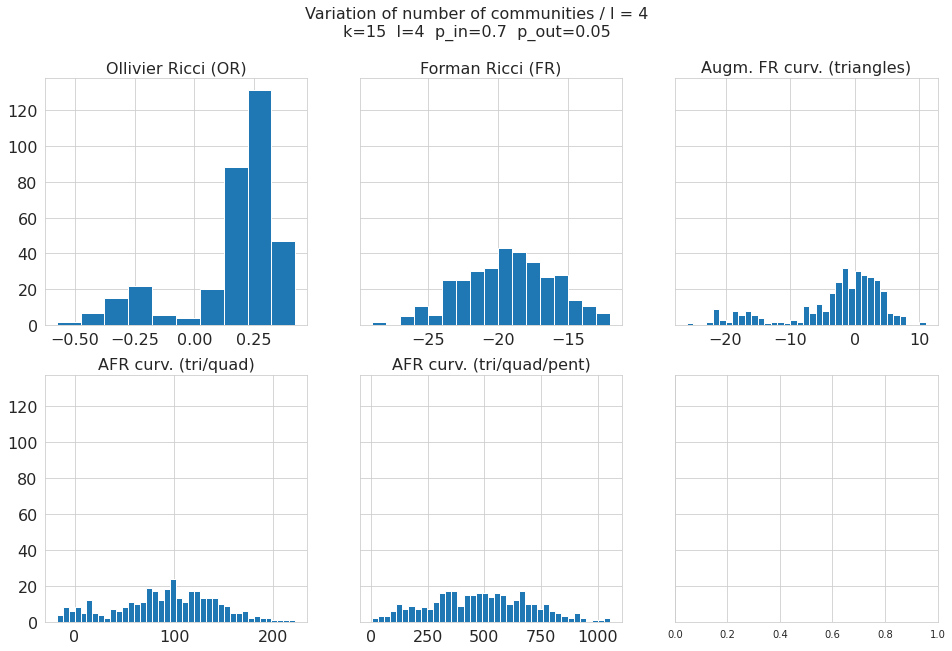


Correlation coefficients:
Ollivier Ricci (OR) / Forman Ricci (FR)................  0.05771
Ollivier Ricci (OR) / Augm. FR curv. (triangles).......  0.93917
Ollivier Ricci (OR) / AFR curv. (tri/quad).............  0.79722
Ollivier Ricci (OR) / AFR curv. (tri/quad/pent)........  0.70267

Forman Ricci (FR) / Augm. FR curv. (triangles).........  0.02245
Forman Ricci (FR) / AFR curv. (tri/quad)............... -0.40935
Forman Ricci (FR) / AFR curv. (tri/quad/pent).......... -0.51140

Augm. FR curv. (triangles) / AFR curv. (tri/quad)......  0.82209
Augm. FR curv. (triangles) / AFR curv. (tri/quad/pent).  0.71464

AFR curv. (tri/quad) / AFR curv. (tri/quad/pent).......  0.97043


k: 15  l: 5  p_in: 0.7  p_out: 0.05

Min/Max Curvature values:
orc      Min:   -0.4391    Max:    0.4167
frc      Min:  -29.0000    Max:  -12.0000
afrc     Min:  -26.0000    Max:    8.0000
afrc4    Min:  -20.0000    Max:  204.0000
afrc5    Min:   43.0000    Max:  1017.0000



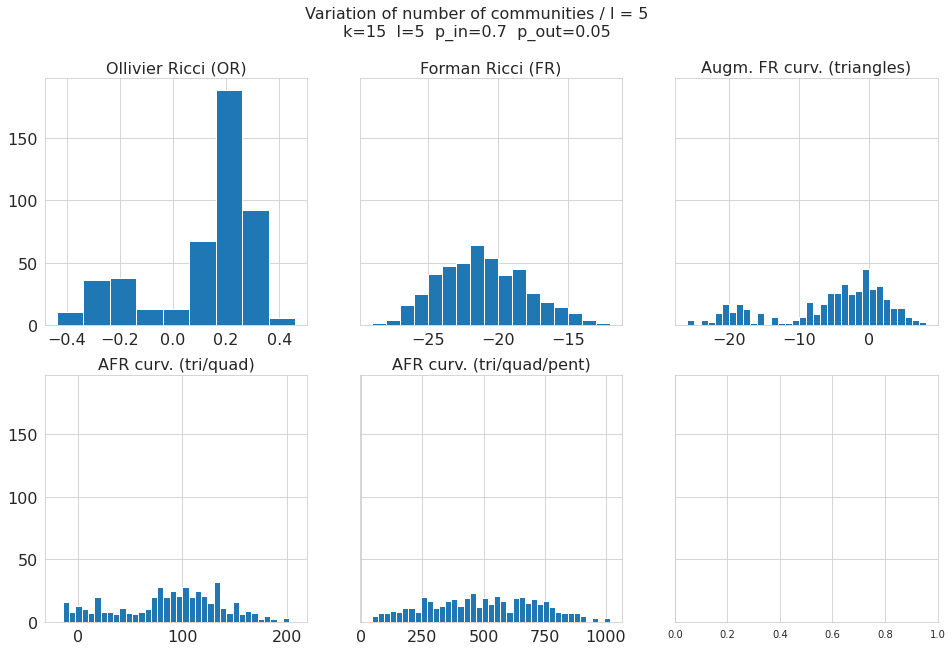


Correlation coefficients:
Ollivier Ricci (OR) / Forman Ricci (FR)................  0.11191
Ollivier Ricci (OR) / Augm. FR curv. (triangles).......  0.94509
Ollivier Ricci (OR) / AFR curv. (tri/quad).............  0.84907
Ollivier Ricci (OR) / AFR curv. (tri/quad/pent)........  0.74322

Forman Ricci (FR) / Augm. FR curv. (triangles).........  0.15090
Forman Ricci (FR) / AFR curv. (tri/quad)............... -0.25266
Forman Ricci (FR) / AFR curv. (tri/quad/pent).......... -0.39898

Augm. FR curv. (triangles) / AFR curv. (tri/quad)......  0.83609
Augm. FR curv. (triangles) / AFR curv. (tri/quad/pent).  0.71492

AFR curv. (tri/quad) / AFR curv. (tri/quad/pent).......  0.96491


k: 15  l: 5  p_in: 0.6  p_out: 0.05

Min/Max Curvature values:
orc      Min:   -0.4500    Max:    0.3636
frc      Min:  -27.0000    Max:  -10.0000
afrc     Min:  -24.0000    Max:    6.0000
afrc4    Min:  -16.0000    Max:  138.0000
afrc5    Min:   14.0000    Max:  573.0000



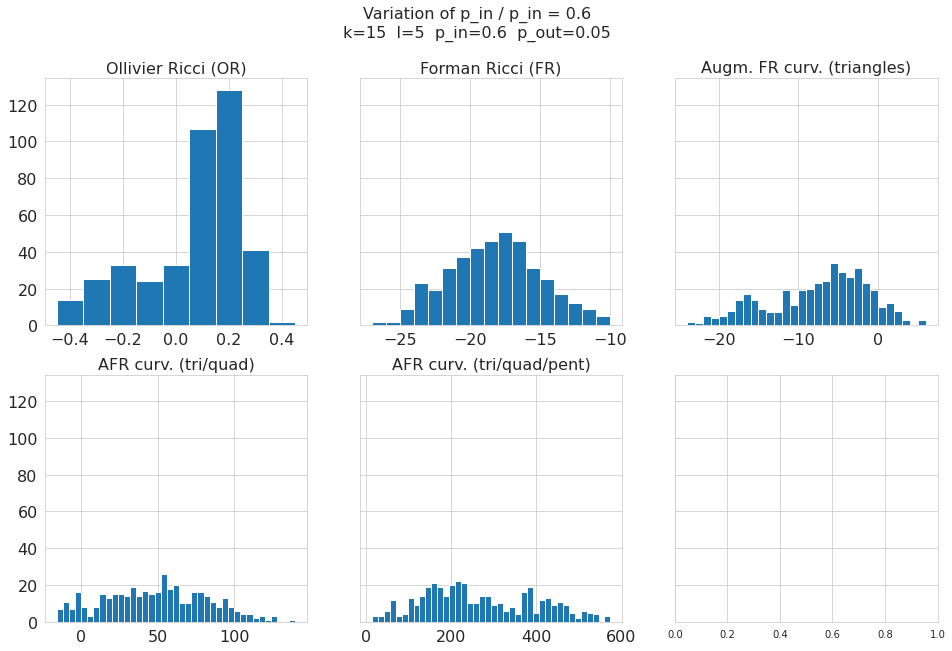


Correlation coefficients:
Ollivier Ricci (OR) / Forman Ricci (FR)................  0.07206
Ollivier Ricci (OR) / Augm. FR curv. (triangles).......  0.89905
Ollivier Ricci (OR) / AFR curv. (tri/quad).............  0.81723
Ollivier Ricci (OR) / AFR curv. (tri/quad/pent)........  0.67833

Forman Ricci (FR) / Augm. FR curv. (triangles).........  0.22079
Forman Ricci (FR) / AFR curv. (tri/quad)............... -0.32060
Forman Ricci (FR) / AFR curv. (tri/quad/pent).......... -0.50033

Augm. FR curv. (triangles) / AFR curv. (tri/quad)......  0.74397
Augm. FR curv. (triangles) / AFR curv. (tri/quad/pent).  0.56345

AFR curv. (tri/quad) / AFR curv. (tri/quad/pent).......  0.95034


k: 15  l: 5  p_in: 0.7  p_out: 0.05

Min/Max Curvature values:
orc      Min:   -0.4391    Max:    0.4167
frc      Min:  -29.0000    Max:  -12.0000
afrc     Min:  -26.0000    Max:    8.0000
afrc4    Min:  -20.0000    Max:  204.0000
afrc5    Min:   43.0000    Max:  1017.0000



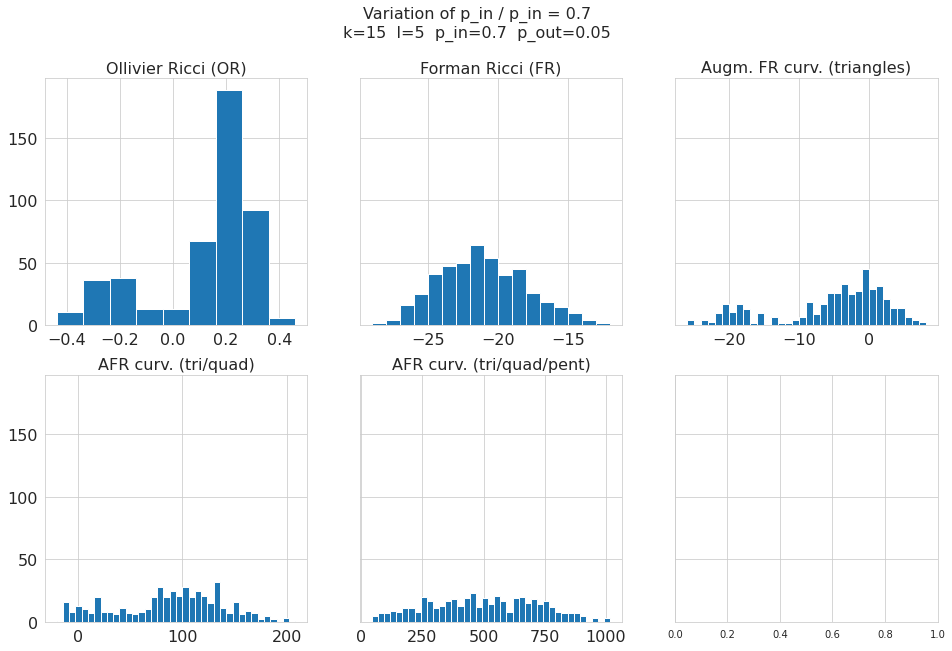


Correlation coefficients:
Ollivier Ricci (OR) / Forman Ricci (FR)................  0.11191
Ollivier Ricci (OR) / Augm. FR curv. (triangles).......  0.94509
Ollivier Ricci (OR) / AFR curv. (tri/quad).............  0.84907
Ollivier Ricci (OR) / AFR curv. (tri/quad/pent)........  0.74322

Forman Ricci (FR) / Augm. FR curv. (triangles).........  0.15090
Forman Ricci (FR) / AFR curv. (tri/quad)............... -0.25266
Forman Ricci (FR) / AFR curv. (tri/quad/pent).......... -0.39898

Augm. FR curv. (triangles) / AFR curv. (tri/quad)......  0.83609
Augm. FR curv. (triangles) / AFR curv. (tri/quad/pent).  0.71492

AFR curv. (tri/quad) / AFR curv. (tri/quad/pent).......  0.96491


k: 15  l: 5  p_in: 0.8  p_out: 0.05

Min/Max Curvature values:
orc      Min:   -0.4145    Max:    0.4762
frc      Min:  -31.0000    Max:  -15.0000
afrc     Min:  -29.0000    Max:   14.0000
afrc4    Min:  -21.0000    Max:  398.0000
afrc5    Min:   65.0000    Max:  2166.0000



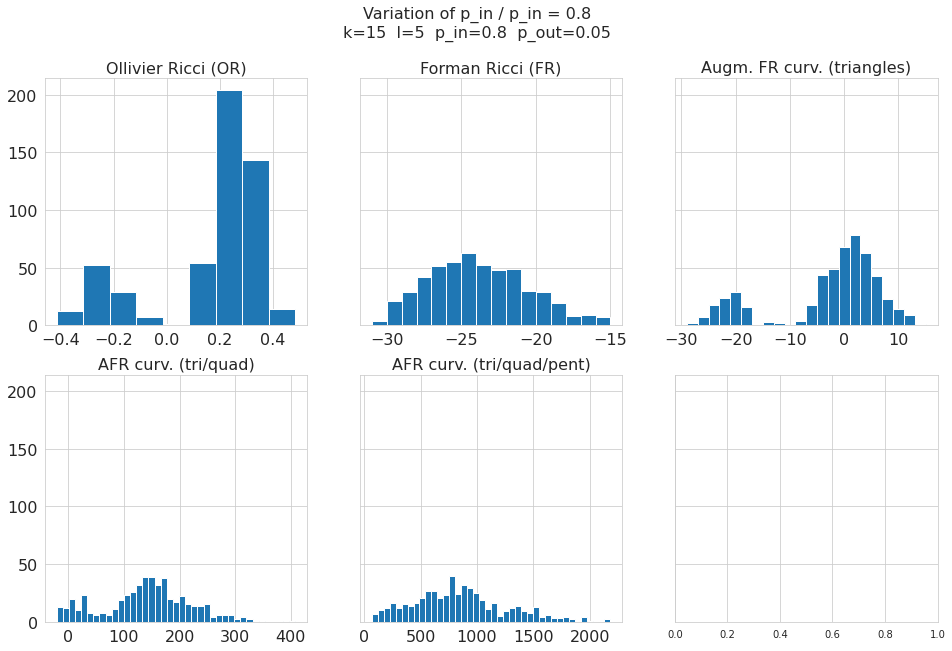


Correlation coefficients:
Ollivier Ricci (OR) / Forman Ricci (FR)................  0.10126
Ollivier Ricci (OR) / Augm. FR curv. (triangles).......  0.95829
Ollivier Ricci (OR) / AFR curv. (tri/quad).............  0.81873
Ollivier Ricci (OR) / AFR curv. (tri/quad/pent)........  0.71072

Forman Ricci (FR) / Augm. FR curv. (triangles).........  0.06956
Forman Ricci (FR) / AFR curv. (tri/quad)............... -0.28828
Forman Ricci (FR) / AFR curv. (tri/quad/pent).......... -0.40883

Augm. FR curv. (triangles) / AFR curv. (tri/quad)......  0.86032
Augm. FR curv. (triangles) / AFR curv. (tri/quad/pent).  0.76347

AFR curv. (tri/quad) / AFR curv. (tri/quad/pent).......  0.97319


k: 15  l: 5  p_in: 0.9  p_out: 0.05

Min/Max Curvature values:
orc      Min:   -0.4167    Max:    0.4762
frc      Min:  -32.0000    Max:  -19.0000
afrc     Min:  -30.0000    Max:   15.0000
afrc4    Min:  -19.0000    Max:  449.0000
afrc5    Min:  129.0000    Max:  2528.0000



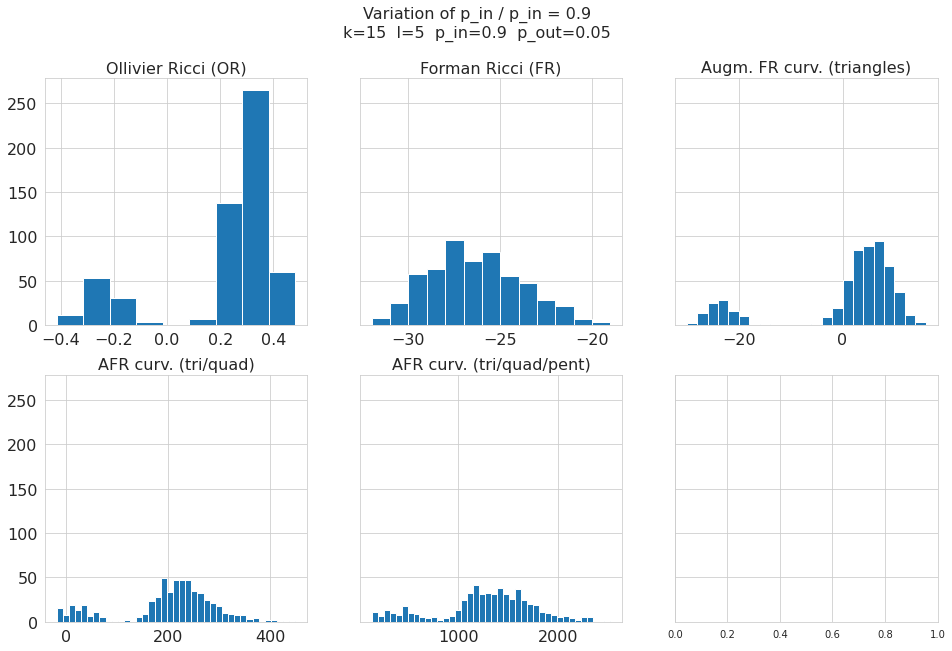


Correlation coefficients:
Ollivier Ricci (OR) / Forman Ricci (FR)................  0.23034
Ollivier Ricci (OR) / Augm. FR curv. (triangles).......  0.97528
Ollivier Ricci (OR) / AFR curv. (tri/quad).............  0.87702
Ollivier Ricci (OR) / AFR curv. (tri/quad/pent)........  0.82409

Forman Ricci (FR) / Augm. FR curv. (triangles).........  0.23115
Forman Ricci (FR) / AFR curv. (tri/quad)............... -0.01147
Forman Ricci (FR) / AFR curv. (tri/quad/pent).......... -0.10606

Augm. FR curv. (triangles) / AFR curv. (tri/quad)......  0.89412
Augm. FR curv. (triangles) / AFR curv. (tri/quad/pent).  0.84090

AFR curv. (tri/quad) / AFR curv. (tri/quad/pent).......  0.98585


k: 15  l: 5  p_in: 0.7  p_out: 0.05

Min/Max Curvature values:
orc      Min:   -0.4391    Max:    0.4167
frc      Min:  -29.0000    Max:  -12.0000
afrc     Min:  -26.0000    Max:    8.0000
afrc4    Min:  -20.0000    Max:  204.0000
afrc5    Min:   43.0000    Max:  1017.0000



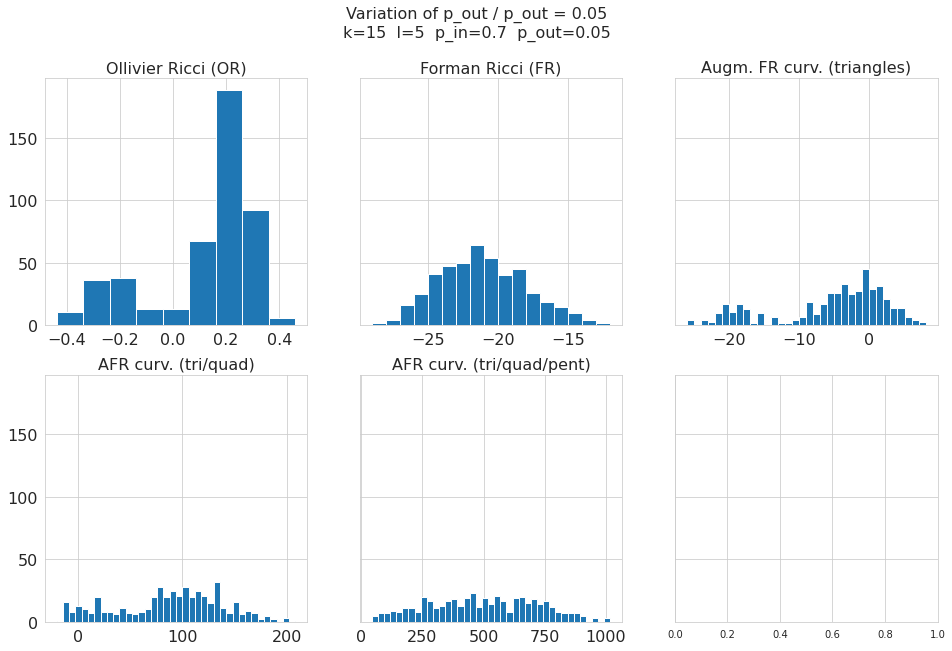


Correlation coefficients:
Ollivier Ricci (OR) / Forman Ricci (FR)................  0.11191
Ollivier Ricci (OR) / Augm. FR curv. (triangles).......  0.94509
Ollivier Ricci (OR) / AFR curv. (tri/quad).............  0.84907
Ollivier Ricci (OR) / AFR curv. (tri/quad/pent)........  0.74322

Forman Ricci (FR) / Augm. FR curv. (triangles).........  0.15090
Forman Ricci (FR) / AFR curv. (tri/quad)............... -0.25266
Forman Ricci (FR) / AFR curv. (tri/quad/pent).......... -0.39898

Augm. FR curv. (triangles) / AFR curv. (tri/quad)......  0.83609
Augm. FR curv. (triangles) / AFR curv. (tri/quad/pent).  0.71492

AFR curv. (tri/quad) / AFR curv. (tri/quad/pent).......  0.96491


k: 15  l: 5  p_in: 0.7  p_out: 0.03

Min/Max Curvature values:
orc      Min:   -0.6667    Max:    0.4583
frc      Min:  -27.0000    Max:   -8.0000
afrc     Min:  -25.0000    Max:   10.0000
afrc4    Min:  -21.0000    Max:  238.0000
afrc5    Min:    8.0000    Max:  1046.0000



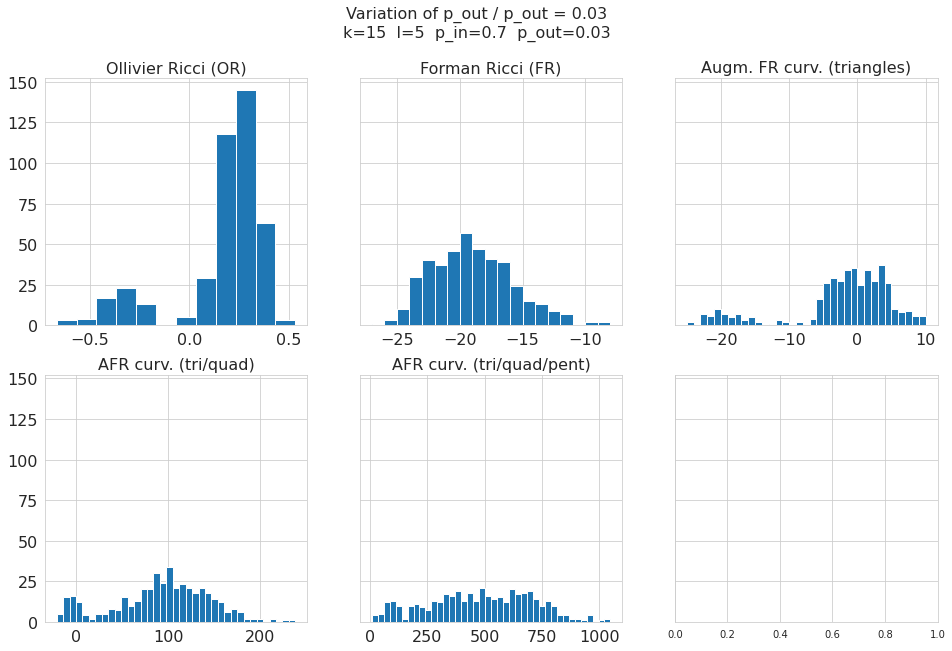


Correlation coefficients:
Ollivier Ricci (OR) / Forman Ricci (FR)................  0.15857
Ollivier Ricci (OR) / Augm. FR curv. (triangles).......  0.93912
Ollivier Ricci (OR) / AFR curv. (tri/quad).............  0.78328
Ollivier Ricci (OR) / AFR curv. (tri/quad/pent)........  0.69080

Forman Ricci (FR) / Augm. FR curv. (triangles).........  0.06468
Forman Ricci (FR) / AFR curv. (tri/quad)............... -0.34743
Forman Ricci (FR) / AFR curv. (tri/quad/pent).......... -0.45416

Augm. FR curv. (triangles) / AFR curv. (tri/quad)......  0.83655
Augm. FR curv. (triangles) / AFR curv. (tri/quad/pent).  0.73905

AFR curv. (tri/quad) / AFR curv. (tri/quad/pent).......  0.97399


k: 15  l: 5  p_in: 0.7  p_out: 0.02

Min/Max Curvature values:
orc      Min:   -0.6833    Max:    0.4583
frc      Min:  -28.0000    Max:   -9.0000
afrc     Min:  -26.0000    Max:   10.0000
afrc4    Min:  -25.0000    Max:  215.0000
afrc5    Min:   -5.0000    Max:  962.0000



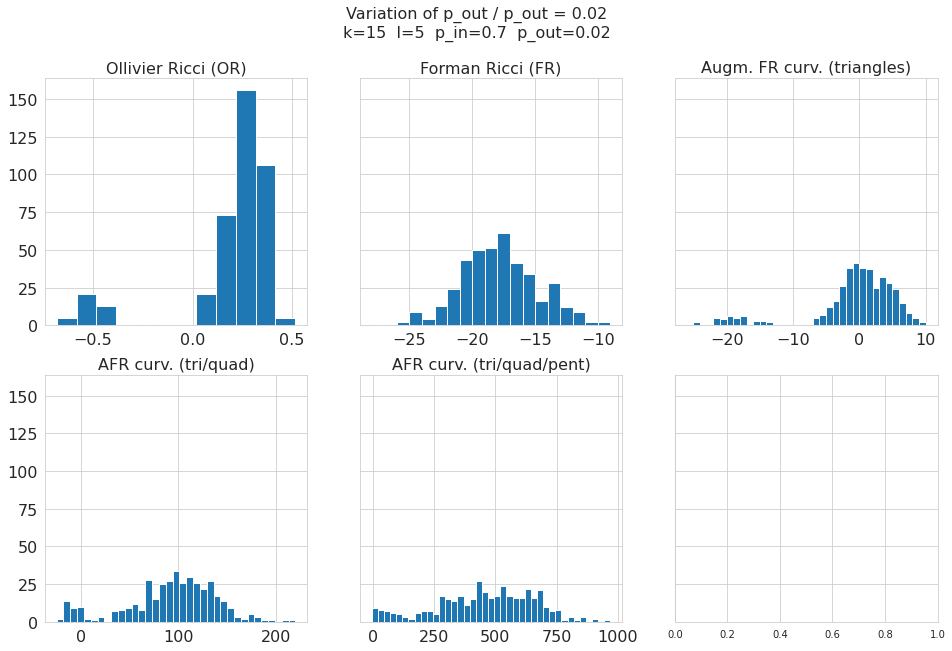


Correlation coefficients:
Ollivier Ricci (OR) / Forman Ricci (FR)................  0.20453
Ollivier Ricci (OR) / Augm. FR curv. (triangles).......  0.94355
Ollivier Ricci (OR) / AFR curv. (tri/quad).............  0.78293
Ollivier Ricci (OR) / AFR curv. (tri/quad/pent)........  0.71429

Forman Ricci (FR) / Augm. FR curv. (triangles).........  0.09006
Forman Ricci (FR) / AFR curv. (tri/quad)............... -0.30868
Forman Ricci (FR) / AFR curv. (tri/quad/pent).......... -0.36976

Augm. FR curv. (triangles) / AFR curv. (tri/quad)......  0.82697
Augm. FR curv. (triangles) / AFR curv. (tri/quad/pent).  0.75069

AFR curv. (tri/quad) / AFR curv. (tri/quad/pent).......  0.97554


k: 15  l: 5  p_in: 0.7  p_out: 0.01

Min/Max Curvature values:
orc      Min:   -0.8091    Max:    0.5000
frc      Min:  -24.0000    Max:   -8.0000
afrc     Min:  -24.0000    Max:   12.0000
afrc4    Min:  -22.0000    Max:  260.0000
afrc5    Min:  -17.0000    Max:  1143.0000



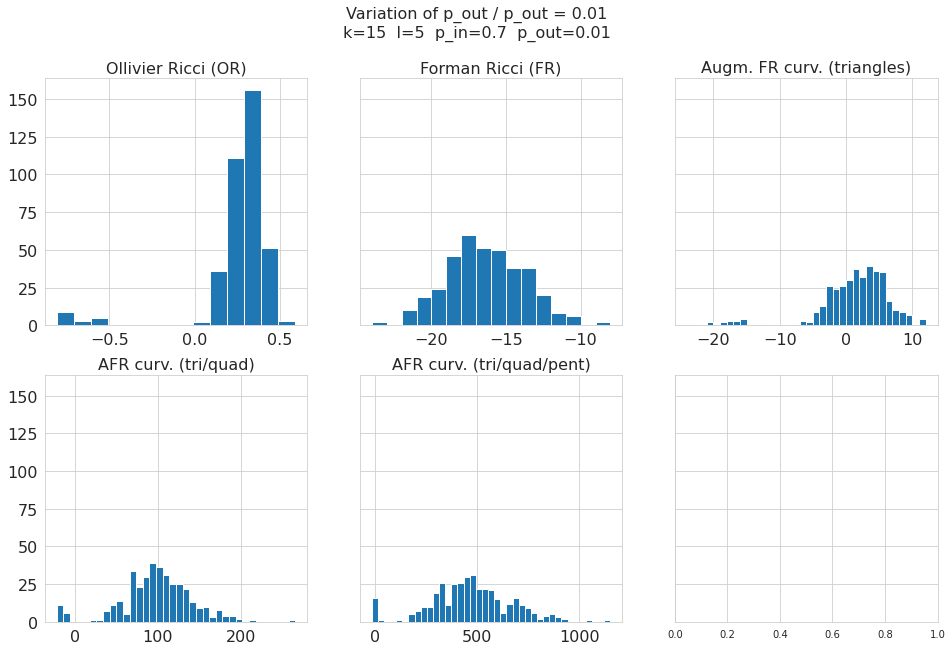


Correlation coefficients:
Ollivier Ricci (OR) / Forman Ricci (FR)................ -0.04712
Ollivier Ricci (OR) / Augm. FR curv. (triangles).......  0.89550
Ollivier Ricci (OR) / AFR curv. (tri/quad).............  0.71572
Ollivier Ricci (OR) / AFR curv. (tri/quad/pent)........  0.65388

Forman Ricci (FR) / Augm. FR curv. (triangles)......... -0.28155
Forman Ricci (FR) / AFR curv. (tri/quad)............... -0.58557
Forman Ricci (FR) / AFR curv. (tri/quad/pent).......... -0.59315

Augm. FR curv. (triangles) / AFR curv. (tri/quad)......  0.80036
Augm. FR curv. (triangles) / AFR curv. (tri/quad/pent).  0.72972

AFR curv. (tri/quad) / AFR curv. (tri/quad/pent).......  0.97557




In [145]:
d = calculate_SBMs()  